In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy


plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Arial"

sc.set_figure_params(figsize=(4, 4))

sc.set_figure_params(figsize=(4, 4))
sc.settings.figdir = './figures_sPAX8/'


palette = ['#fbbc04', '#199de5', '#cfe6d5']

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# SOMATIC early

### Read in dataset

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [4]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

## Annotate cells

In [5]:
# Add old cluster subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_female_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

metaM = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaM = metaM.set_index('Unnamed: 0')
metaM.head()


cell_annotM = metaM['lineage'].to_dict()
cell_annotF = metaF['lineage'].to_dict()
cell_annot = {**cell_annotM , **cell_annotF}
adata.obs['lineage'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# Add old cluster subname
meta = pd.read_csv(path_to_gonads+'FCA-gonads_somatic_annotated.csv')
meta = meta.set_index('Unnamed: 0')
meta.head()

cell_annot = meta['celltype'].to_dict()
adata.obs['celltype_somatic'] = adata.obs_names.map(cell_annot).astype('category')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30,37) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,24297,0.061269
Doublet,5821,0.014679
Endothelial,14484,0.036524
Epithelial,20222,0.050993
Erythroid,1371,0.003457
FetalLeydig,2426,0.006118
GermCells,14516,0.036604
Immune,5533,0.013952
Mesenchymal_GATA2,84229,0.212396


In [8]:
adata = adata[[ float(i) <= 12 for i in adata.obs.PCW ]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.celltype_somatic]]
adata = adata[[i in ['Supporting', 'CoelEpi', 'Epithelial', 'Sertoli'] for i in adata.obs.lineage]]
adata = adata[[i not in ['OSE', 'Oi', 'Ti', 'cont', 'granulosa', 'lowQC', 'preGC_IIa', 'preGC_IIb', 'FetalLeydig'] for i in adata.obs.celltype_somatic]]
adata.X.shape

adata.obs['celltype_somatic'] = adata.obs['celltype_somatic'].tolist()
adata.obs['celltype_somatic'] = adata.obs['celltype_somatic'].fillna(adata.obs['lineage'])
adata.obs['celltype_somatic'] = adata.obs['celltype_somatic'].astype('category')
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.obs` of view, copying.


(60064, 28820)

In [9]:
adata.obs['lineage'].values.describe()

,counts,freqs
categories,,
CoelEpi,12651,0.210625
Epithelial,12288,0.204582
Sertoli,11512,0.191662
Supporting,23613,0.393131


In [10]:
adata.obs['celltype_somatic'].values.describe()

,counts,freqs
categories,,
CoelEpi,534,0.008891
CoelEpi_GATA2,4014,0.066829
CoelEpi_LHX9,4002,0.066629
CoelEpi_LHX9_cycling,1852,0.030834
Epithelial,12288,0.204582
Gi,3295,0.054858
Sertoli,12306,0.204881
Supporting,235,0.003912
early_sPAX8,3518,0.058571


In [11]:
sc.pp.filter_genes(adata, min_counts=5)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 60064
Total number of genes: 24843


### Identify HVGs

In [13]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3"
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True


In [14]:
# subset object for latter
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Load latent space scVI

In [16]:
X_scVI = pd.read_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_sPAX8.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Clustering

In [17]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3, spread = 1.1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


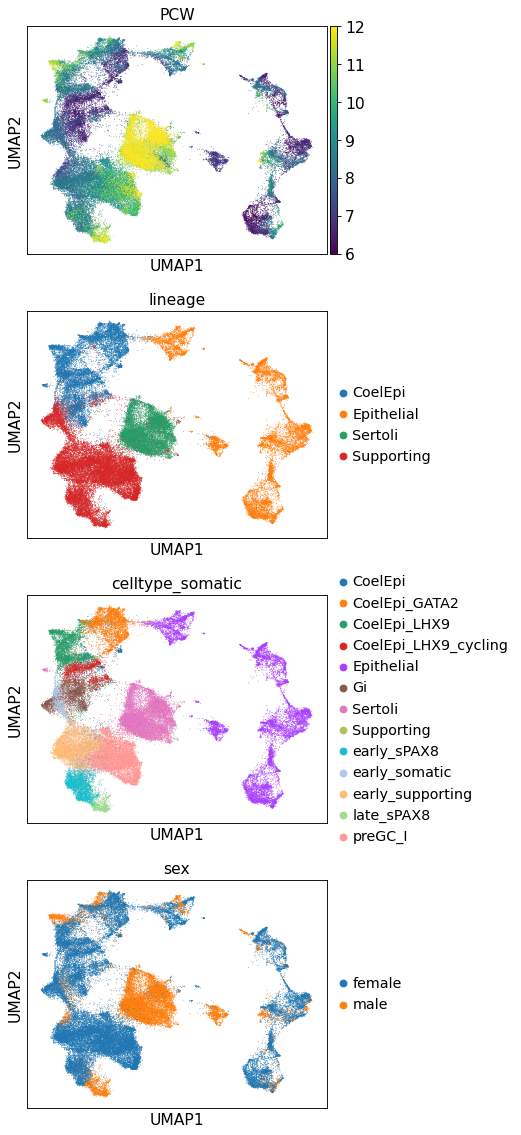

In [18]:
sc.pl.umap(
    adata,
    color=['PCW',   "lineage", 'celltype_somatic', 'sex'], 
    frameon=True, ncols = 1, wspace = 0.3
)

# Explore data

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


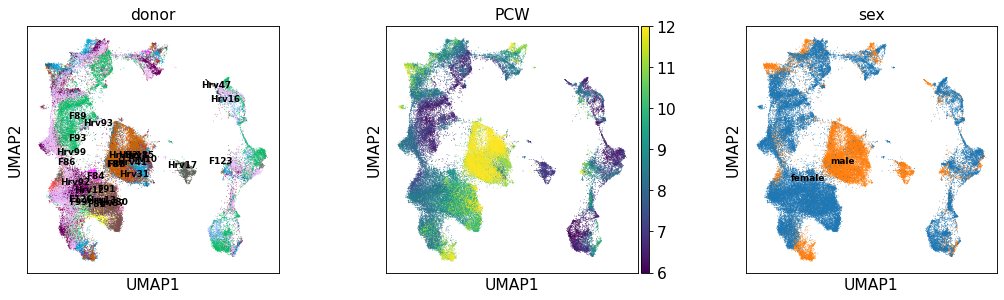

In [19]:
sc.tl.leiden(adata, resolution=1)
sc.pl.umap(
    adata,
    color=['donor', 'PCW', 'sex'], legend_loc='on data',legend_fontsize=8, ncols = 3,
    frameon=True,  wspace = 0.3
)

# Remove no-first wave

In [20]:
adata = adata[[i not in ['lowQC', 'Doublet', 'cont'] for i in adata.obs.lineage]]
adata = adata[[i not in ['lowQC', 'Doublet', 'cont', 'Mesenchymal_LHX9', 'Supporting', 'Oi', 'Ti', 'FetalLeydig', 'preGranulosa', 'CoelEpi', 'preGC_IIa', 'preGC_IIb', 'OSE'] for i in adata.obs.celltype_somatic]]
adata.obs['celltype_somatic'].values.describe()

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


,counts,freqs
categories,,
CoelEpi_GATA2,4014,0.067695
CoelEpi_LHX9,4002,0.067493
CoelEpi_LHX9_cycling,1852,0.031234
Epithelial,12288,0.207235
Gi,3295,0.055570
Sertoli,12306,0.207539
early_sPAX8,3518,0.059330
early_somatic,1288,0.021722
early_supporting,5854,0.098727


In [21]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 59295
Total number of genes: 24843


,counts,freqs
categories,,
F81,2875,0.048486
F84,1110,0.018720
F86,2171,0.036614
F87,285,0.004806
F88,4008,0.067594
F89,825,0.013913
F91,746,0.012581
F93,30,0.000506
F99,2432,0.041015


## Annotate clusters

Trying to set attribute `.uns` of view, copying.


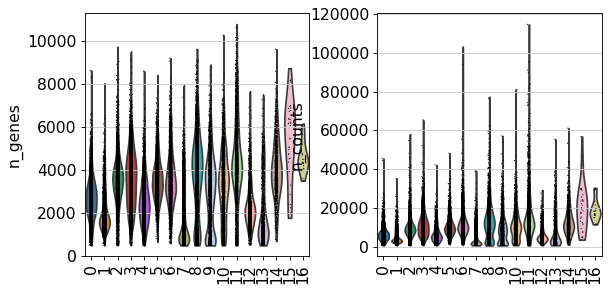

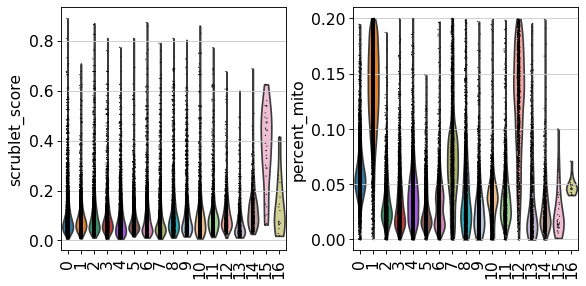

In [22]:
# identify lowQC
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden', rotation=90)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


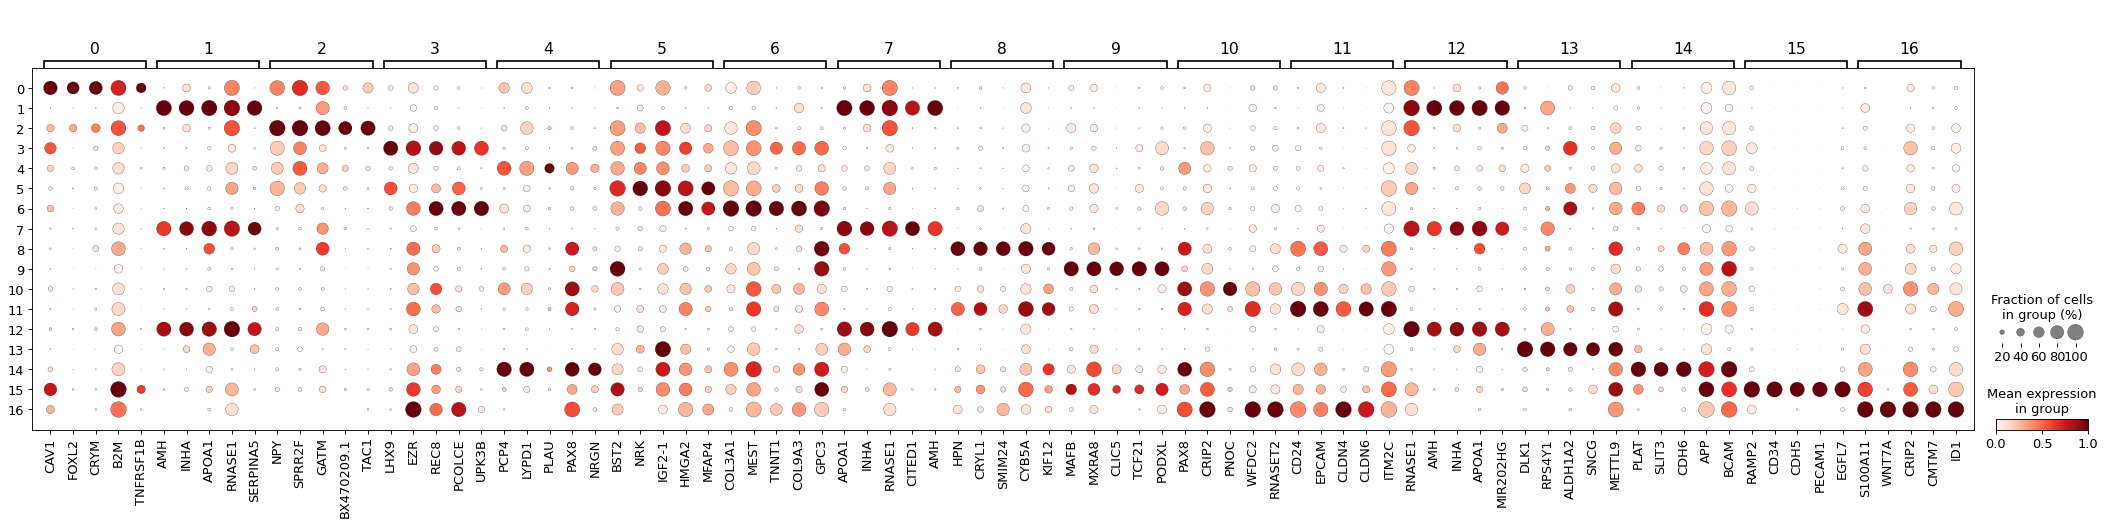

In [23]:
bdata.obs['leiden'] = adata.obs['leiden']
sc.tl.rank_genes_groups(bdata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(bdata, n_genes=5, dendrogram=False, use_raw = False, standard_scale = 'var')

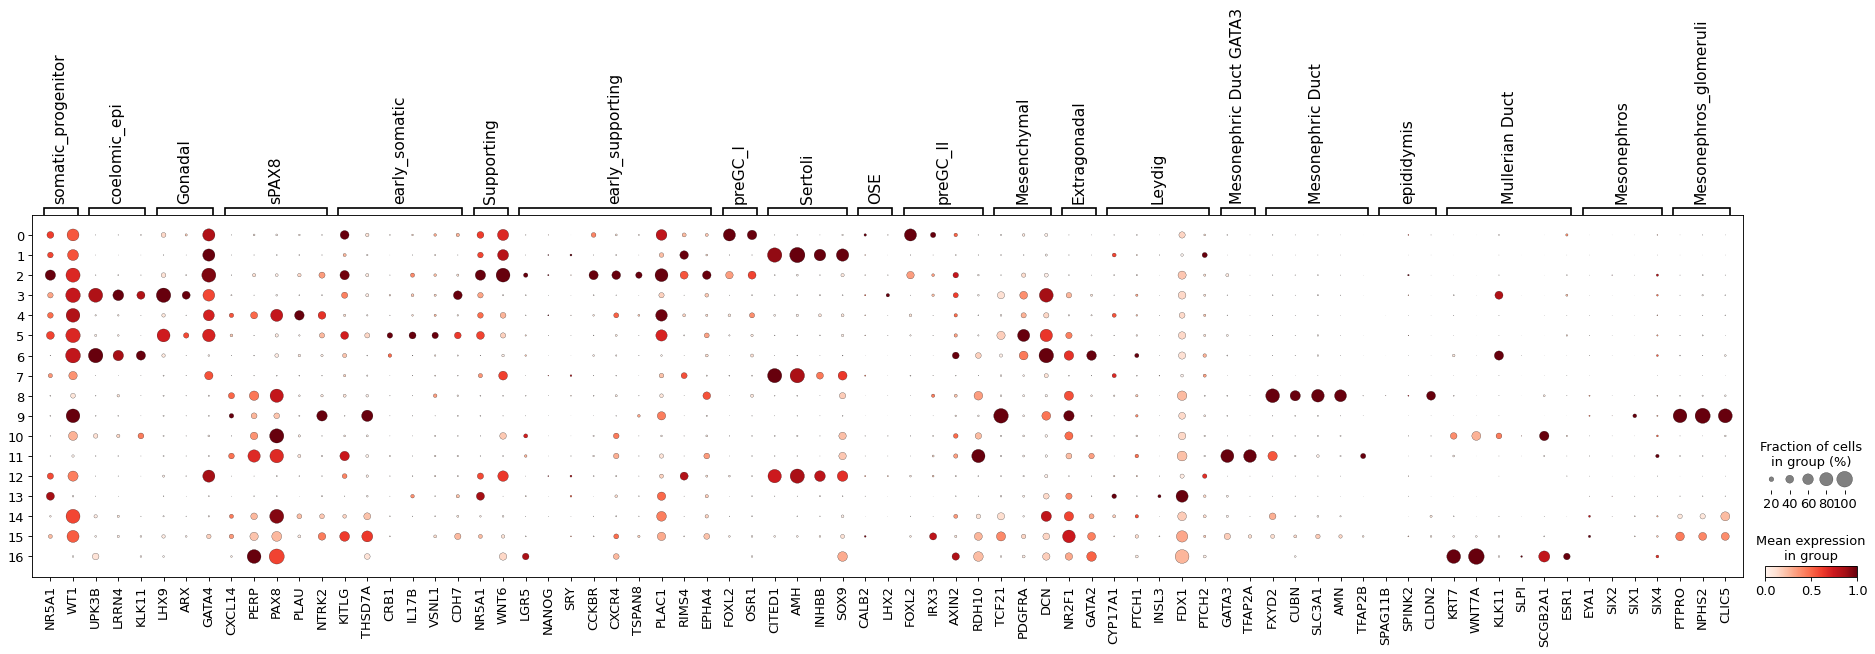

In [24]:
marker_genes = {
    'somatic_progenitor':{'WT1', 'NR5A1'},
    'coelomic_epi': {'LRRN4', 'UPK3B', 'KLK11'},
    'Gonadal':{'LHX9', 'GATA4', 'ARX'},
    'sPAX8': {'PAX8', 'PLAU', 'PERP', 'NTRK2',  'CXCL14'},
    'early_somatic': {'IL17B', 'KITLG', 'VSNL1', 'CDH7' ,'CRB1', 'THSD7A'},
    'Supporting':{"WNT6", 'NR5A1'},
    'early_supporting':{'LGR5', 'TSPAN8', 'SRY', 'PLAC1', 'EPHA4', 'CXCR4','NANOG',  'RIMS4', 'CCKBR'},
    'preGC_I':{'OSR1', 'FOXL2'},
    'Sertoli': {'AMH', 'CITED1',  'INHBB','SOX9'},
    'OSE':{'LHX2', 'CALB2'},
    'preGC_II':{'FOXL2', "IRX3", "RDH10", 'AXIN2'},
    'Mesenchymal':{'DCN', 'PDGFRA', 'TCF21'},
    'Extragonadal':{'NR2F1', 'GATA2'},
    'Leydig':{'FDX1', 'INSL3',  'PTCH1',  'PTCH2', 'CYP17A1'},
    'Mesonephric Duct GATA3':{'GATA3', 'TFAP2A'},
    'Mesonephric Duct':{'FXYD2', 'TFAP2B', 'AMN', 'CUBN', 'SLC3A1'},
    'epididymis':{'SPINK2', 'SPAG11B', 'CLDN2'},
    'Mullerian Duct':{'SLPI', 'WNT7A', 'SCGB2A1', 'KRT7', 'KLK11', 'ESR1'},
    'Mesonephros': {'EYA1', 'SIX1', 'SIX4', 'SIX2'},
    'Mesonephros_glomeruli': {"NPHS2", "CLIC5", "PTPRO"}
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale = 'var')


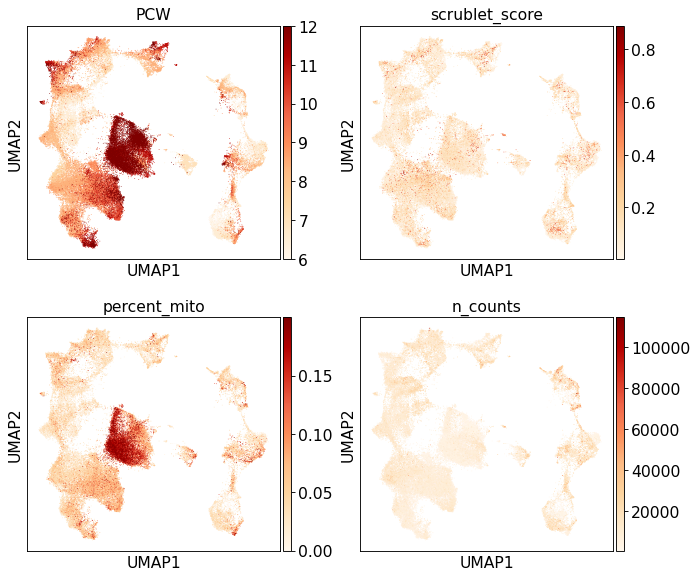

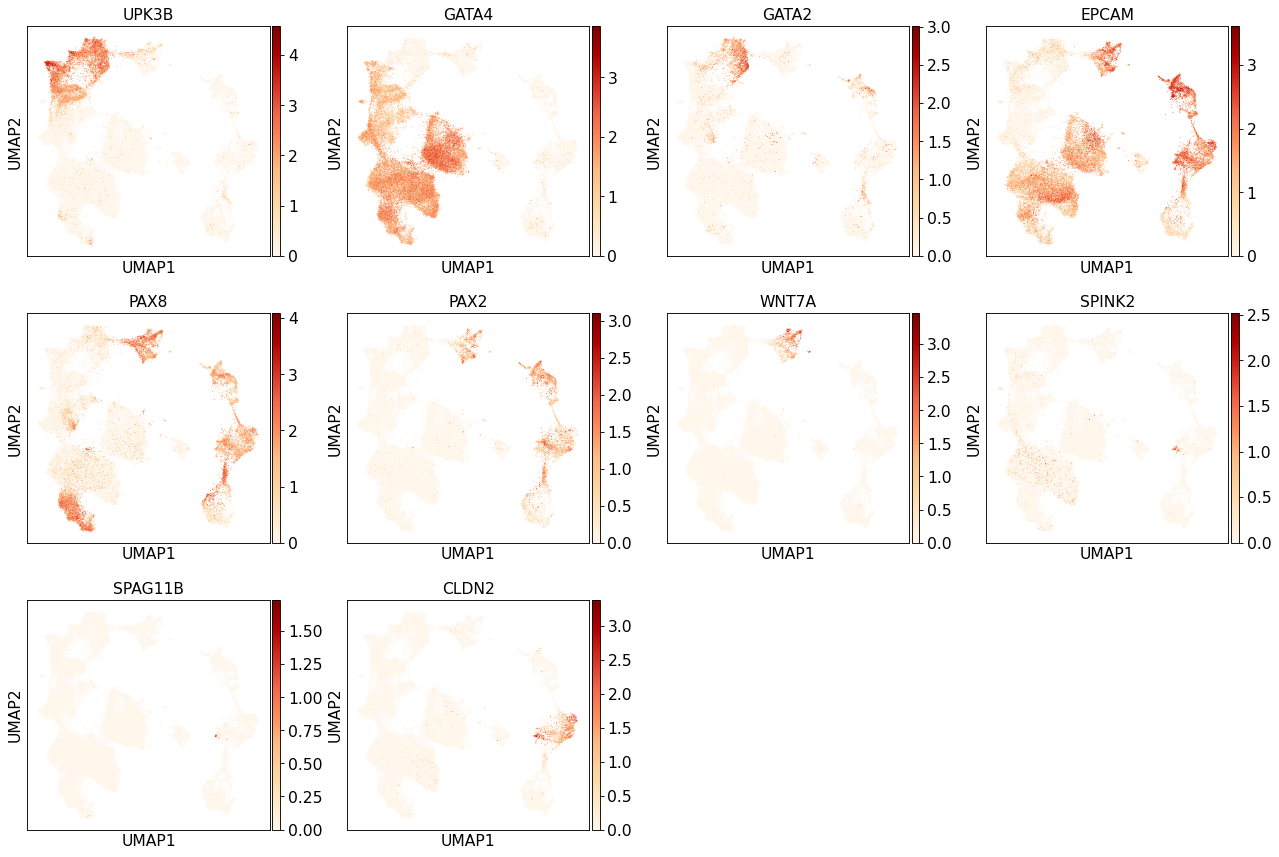

In [25]:
sc.pl.umap(
    adata,
    color=['PCW', 'scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.2
)

sc.pl.umap(
    adata,
    color=[ 'UPK3B', 'GATA4', 'GATA2', 'EPCAM', 'PAX8', 'PAX2', 'WNT7A', 'SPINK2', 'SPAG11B', 'CLDN2'], color_map = "OrRd",
    frameon=True, ncols = 4, wspace = 0.2
)

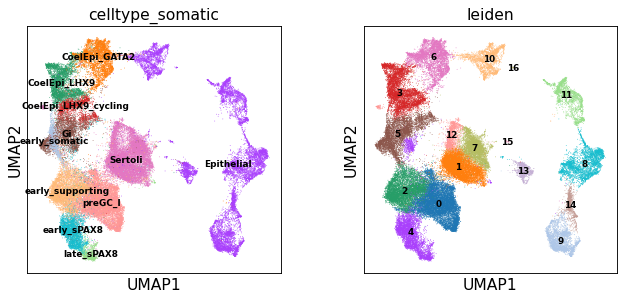

In [26]:
sc.pl.umap(
    adata,
    color=["celltype_somatic", 'leiden'], ncols = 2,
    legend_loc='on data', legend_fontsize=8
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


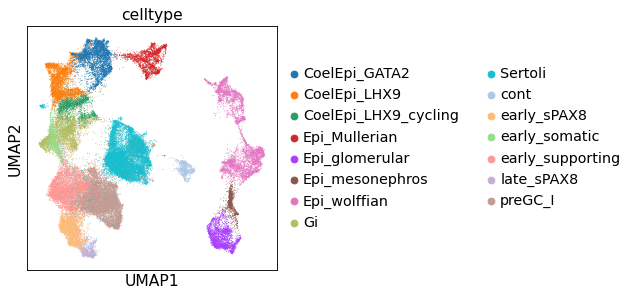

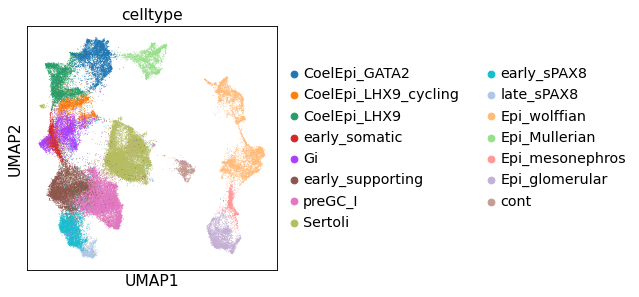

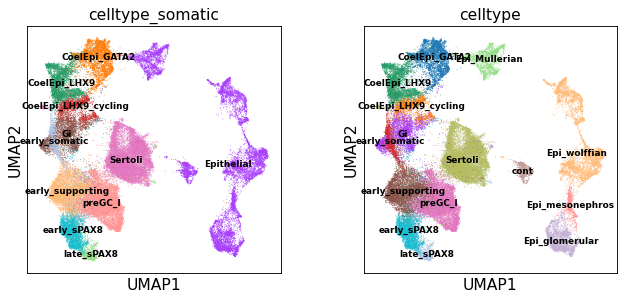

In [27]:
adata.obs['celltype'] = adata.obs['celltype_somatic'].tolist()
adata.obs.at[adata.obs['leiden'] == '8', 'celltype'] = 'Epi_wolffian'
adata.obs.at[adata.obs['leiden'] == '11', 'celltype'] = 'Epi_wolffian'
adata.obs.at[adata.obs['leiden'] == '9', 'celltype'] = 'Epi_glomerular'
adata.obs.at[adata.obs['leiden'] == '14', 'celltype'] = 'Epi_mesonephros'
adata.obs.at[adata.obs['leiden'] == '13', 'celltype'] = 'cont'
adata.obs.at[adata.obs['leiden'] == '10', 'celltype'] = 'Epi_Mullerian'
adata = adata[[i not in ['Epithelial'] for i in adata.obs.celltype]]
set(adata.obs['celltype'])
sc.pl.umap(adata, color=['celltype'])
adata.obs['celltype'].cat.reorder_categories(['CoelEpi_GATA2', 'CoelEpi_LHX9_cycling','CoelEpi_LHX9',  
                                             'early_somatic',  'Gi',
                                              'early_supporting', 'preGC_I',  'Sertoli', 
                                              'early_sPAX8', 'late_sPAX8', 
                                              'Epi_wolffian', 'Epi_Mullerian', 'Epi_mesonephros', 'Epi_glomerular',
                                            'cont'], inplace=True)

sc.pl.umap(adata, color=['celltype'])
sc.pl.umap(adata, color=['celltype_somatic', 'celltype'], ncols = 2, legend_loc='on data', legend_fontsize=8)
adata = adata[[i not in ['cont'] for i in adata.obs.celltype]]

## PLOT metadata with colors

In [28]:
colorsGen_df = pd.read_csv('gonads_general_colors.csv',index_col=0)
colorsGen_df

colorsSom_df = pd.read_csv('gonads_somatic_colors.csv',index_col=0)
colorsSom_df


colorsEpi_df = pd.read_csv('gonads_epithelial_colors.csv',index_col=0)
colorsEpi_df


colors_df = colorsGen_df.append(colorsSom_df, ignore_index=False).drop_duplicates()
colors_df = colors_df.append(colorsEpi_df, ignore_index=False).drop_duplicates()


idx = [colors_df.index.tolist().index(i) for i in adata.obs['lineage'].cat.categories.tolist() ]
adata.uns['lineage_colors'] = [ colors_df.color[i] for i in idx ]

idx = [colors_df.index.tolist().index(i) for i in adata.obs['celltype'].cat.categories.tolist() ]
adata.uns['celltype_colors'] = [ colors_df.color[i] for i in idx ]

label_annot = colors_df['label'].to_dict()
adata.obs['labels'] = adata.obs['celltype_somatic'].map(label_annot)

colors_df = colors_df.set_index('label')
label2color_annot = colors_df['color'].to_dict()
from natsort import natsorted
x = natsorted(list(set(adata.obs['labels'])))
adata.uns['labels_colors'] = [ label2color_annot[i] for i in  x ]

Trying to set attribute `.uns` of view, copying.


... storing 'labels' as categorical


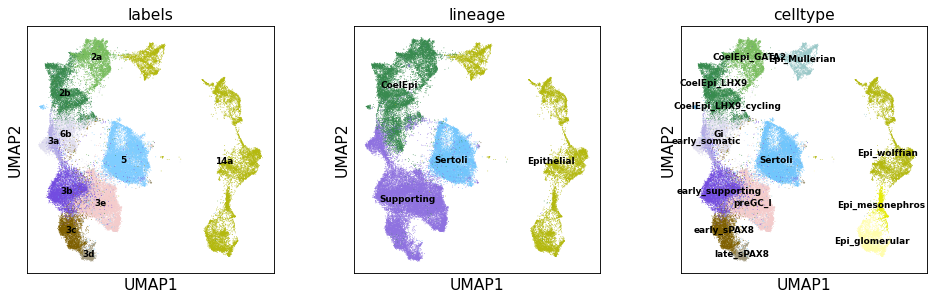

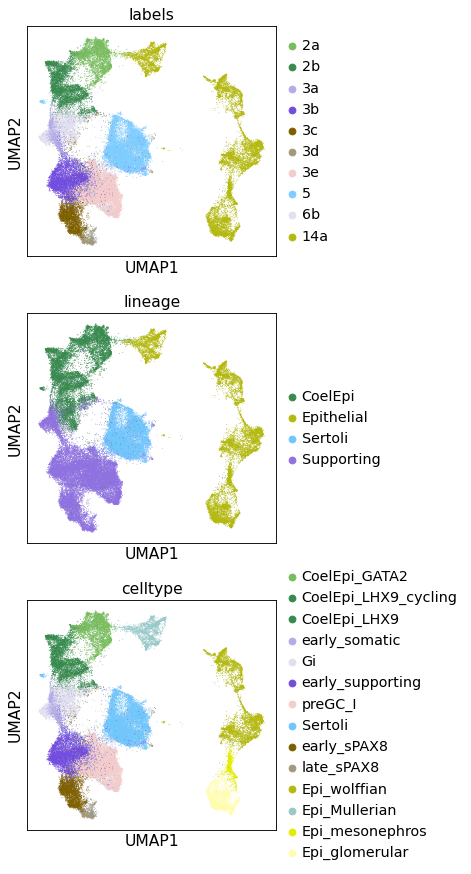

In [29]:
# plt.rcParams['figure.figsize'] = (4,4)
sc.pl.umap(adata, color=['labels', 'lineage', 'celltype'], legend_loc='on data', legend_fontsize=8, save='_human_sPAX8_labelsON.pdf')


with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(adata, color=['labels', 'lineage', 'celltype'], ncols=1, save='_human_sPAX8_legend.pdf')

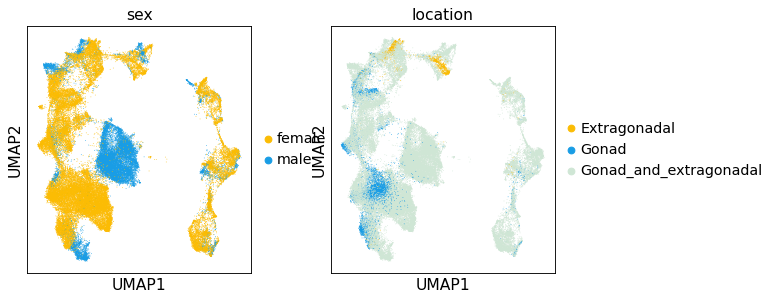

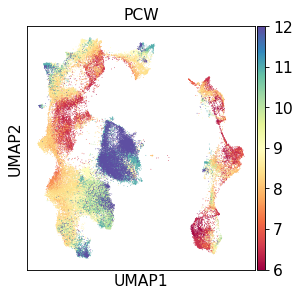

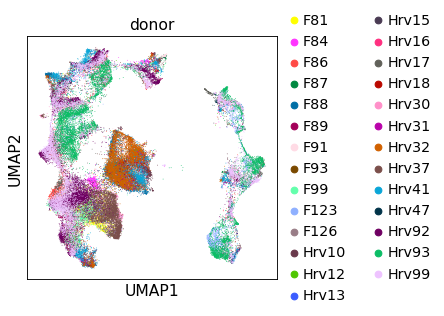

In [30]:
with plt.rc_context({'figure.figsize': (3.5, 4)}):
    sc.pl.umap(adata, color=['sex', 'location'], ncols=2, save='_human_sPAX8_metadata.pdf', palette= palette)

with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(
        adata,
        color=["PCW"], cmap='Spectral',
        frameon=True, ncols = 2, wspace = 0.3, save='_human_sPAX8_PCW.pdf')
    
with plt.rc_context({'figure.figsize': (4, 4)}):
    sc.pl.umap(adata, color=['donor'], ncols=2, save='_human_sPAX8_donor.pdf')  

In [31]:
adata = adata[[i not in ['CoelEpi_LHX9_cycling'] for i in adata.obs.celltype]]
adata.obs['celltype'].cat.reorder_categories(['CoelEpi_GATA2', 'CoelEpi_LHX9',  
                                             'early_somatic',  'Gi',
                                              'early_supporting', 'preGC_I',  'Sertoli', 
                                              'early_sPAX8', 'late_sPAX8', 
                                              'Epi_Mullerian', 'Epi_wolffian', 'Epi_mesonephros', 'Epi_glomerular'], inplace=True)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


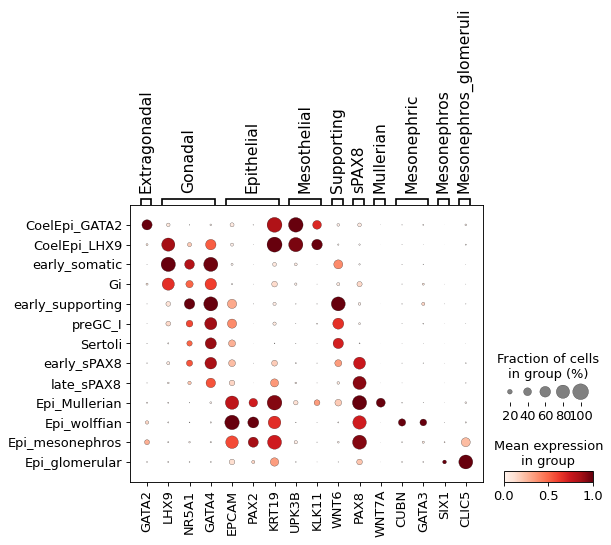

In [32]:
marker_genes_short = {
    'Extragonadal':{'GATA2'},
    'Gonadal':{'GATA4', 'LHX9', 'NR5A1'},
    'Epithelial':{'EPCAM', 'PAX2', 'KRT19'},
    'Mesothelial': {'UPK3B', 'KLK11'},
    'Supporting':{"WNT6"},
    'sPAX8': {'PAX8'},
    'Mullerian':{'WNT7A'},    
#     'Mullerian Duct':{'WNT7A', 'SCGB2A1', 'KRT7'},
    'Mesonephric':{'GATA3', 'CUBN'},
#     'Mesonephric duct':{'GATA3', 'TFAP2A'},
#     'Mesonephric tubules':{'FXYD2', 'AMN', 'CUBN', 'SLC3A1'},
#     'epididymis':{'SPINK2', 'SPAG11B', 'CLDN2'},
    'Mesonephros': ['SIX1'],
    'Mesonephros_glomeruli': {"CLIC5"},
}
sc.pl.dotplot(adata, marker_genes_short, groupby='celltype', standard_scale = 'var', save='_markers.pdf')

In [33]:
adata.obs.to_csv(path_to_gonads+'/FCA-gonads_sPAX8_annotated.csv')
adata.write(path_to_gonads+'/FCA-gonads_sPAX8.h5ad')

In [34]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))
adata.obs['donor'].values.describe()

Total number of cells: 56247
Total number of genes: 24843


,counts,freqs
categories,,
F81,2875,0.051114
F84,1105,0.019645
F86,2160,0.038402
F87,284,0.005049
F88,4008,0.071257
F89,816,0.014507
F91,726,0.012907
F93,26,0.000462
F99,2429,0.043185
